In [25]:
%matplotlib inline
import requests as http
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from lib.lastfm import Lastfm
from lib.spotify import User
import time
import calendar
import datetime
pd.options.display.max_rows = 20
api_key = 'b333a19b2c0397e8e4c1224b49b3e7cd'
api_base = 'http://ws.audioscrobbler.com/2.0/?format=json&'
user_name = 'dude0faw3'
data = http.get(api_base + 'method=user.getrecenttracks&limit=200&api_key='\
                + api_key + '&user=' + user_name).json()

In [26]:
token = 'BQCm2hBHJLd_gCq3QTIIB5iiN2SXZ2jT19v-6OEjrqk4BBclqN4_XgESeIUoOZwQ9gq9wjVoY8NgCtSDR1xWCmMevGFzD9fwD21P-hXWUm5SdvzamWXoEZuuI4feITjNTtk5DHudjoWAavalTCGuphYXhbsGeEGHeFXQq3P3Vlijr04IMGu97stdCZBv9loXV0jd7ovEVxzP'
received_features = ['danceability', 'energy', 'acousticness', 'valence', 'tempo']
user = User(received_features, 40, token=token)
lastfm = Lastfm()

Jewels & Dreams
Sultan + Shepard 
Meg & Dia
Jenna G and Futurebound
T.I. & Playboy Tre


In [27]:
track_data = data['recenttracks']['track']
limit = data['recenttracks']['@attr']['totalPages']
page = 1
history = []
# for nested dictionary entry requests
class FakeNone:
    def get(*args):
        return FakeNone()
# ensures that there's no key error exception
def check_track(track):
    arr = [track.get('name', FakeNone()),
     track.get('artist', FakeNone()).get('#text', FakeNone()),
      track.get('date', FakeNone()).get('uts', FakeNone())
    ]
    return [None if type(x) == FakeNone else x for x in arr]

for track in track_data:
    history.append(check_track(track))
    
print('Starting! There are ' + limit + ' pages')
while int(data['recenttracks']['@attr']['page']) is not int(limit):
    if page % 25 is 0:
        print('Page %i' % page)
    page += 1
    data = http.get(api_base + 'method=user.getrecenttracks&limit=200&api_key=' + api_key + \
                    '&user=' + user_name + '&page=' + str(page)).json()
    for track in data['recenttracks']['track']:
        history.append(check_track(track))



Starting! There are 160 pages
Page 25
Page 50
Page 75
Page 100
Page 125
Page 150


## Goals:
- most listened to songs / artists (as well as during a time)
- songs/artists you've neglected
- genres (tags)

In [40]:
history_df = pd.DataFrame(history)
history_df.columns = ['track_name', 'artists', 'date']
history_df

,track_name,artists,date
0,When I'm Gone - Album Version (Edited),Eminem,1486942843
1,Limelight (NGHTMRE Remix),Just A Gent,1486942591
2,Connect,Drake,1486942237
3,Bet I (Feat. T.I. & Playboy Tre),B.o.B,1486941984
4,Losin Control,Russ,1486941782
5,My Own Worst Enemy,Lit,1486941595
6,All I Ever Wanted,Michael Brun,1486941311
7,Dynamo - Oliver Twizt Trap Remix,Laidback Luke,1486941039
8,Kryptonite,3 Doors Down,1486940809
9,Killer,The Ready Set,1486940587


In [70]:
# determine the n-most frequently played songs from a given pandas series
def determine_frequencies(data, num_songs, neglected=False):
    if neglected:
        counter = Counter(data)
        frequencies = counter.most_common()
        index = len(frequencies) - num_songs
        return frequencies[ index :]
    else:
        counter = Counter(data)
        return counter.most_common(num_songs)

# clean lastfm data to only have songs currently in spotify library
def refine_df(original_df, feature_name, must_haves):
    def check(val):
        for must_have in must_haves:
            if must_have.lower() == val.lower():
                return True
            
        return False
    arr_check = np.vectorize(check)
    return original_df[ arr_check(original_df[ feature_name ]) ]

def set_count(spotify):
    count_arr = [None] * len(spotify)
    for row in spotify.itertuples():
        count = occurences_in_history(row.track_name, row.artists)
        count_arr[row.Index] = count
    spotify['count'] = pd.Series(count_arr)
    
history_songs = history_df['track_name'].values
history_artists = history_df['artists'].values

def occurences_in_history(track_name, track_artists):
    count = 0
    track_artists = track_artists.split(',')
    for track, history_artist in zip(history_songs, history_artists):
        # ignore potential formatting differences
        if track.lower() == track_name.lower():
            for artist in track_artists:
                if artist.lower() == history_artist.lower():
                    count += 1
    return count
        
songs = user.library['track_name']
history_df = refine_df(history_df, 'track_name', songs)
set_count(user.library)

In [71]:
user.library

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
0,Pvrple Forest - Original Mix,5SI3WZ3UyZU8SQzRqPwSzR,GANZ,31,"electronic,seenlive",0.540,0.758,0.000656,0.211,142.131,3
1,Right Now,1tiC8QJASx6lGHBMEpFawS,"Fabian Mazur,Luude",56,"trap,hiphop,futurebass",0.608,0.758,0.144000,0.331,140.031,5
2,Beautiful Girls,5EuAj9nZiWRKeBkgxMXsW4,Sean Kingston,15,"rnb,hiphop",0.745,0.666,0.159000,0.727,129.995,12
3,Cry Me a River,7Lf7oSEVdzZqTA0kEDSlS5,Justin Timberlake,70,"pop,rnb",0.624,0.653,0.575000,0.588,73.884,2
4,Since U Been Gone,3xrn9i8zhNZsTtcoWgQEAd,Kelly Clarkson,69,"pop,femalevocalists",0.662,0.741,0.001650,0.409,131.000,1
5,Kryptonite,6ZOBP3NvffbU4SZcrnt1k6,3 Doors Down,68,"rock,alternativerock",0.545,0.860,0.006240,0.591,99.031,11
6,Stellar - Morgan Page Remix,5eleUvVKuyL8mvOpkEIS2q,"Disco Killerz,Liquid Todd,Jimmy Gnecco,Morgan ...",43,",,house,electronica,singersongwriter,rock,hous...",0.520,0.923,0.042700,0.184,128.004,0
7,My Own Worst Enemy,33iv3wnGMrrDugd7GBso1z,Lit,65,"rock,alternativerock",0.494,0.946,0.001290,0.713,103.408,6
8,Drive,7nnWIPM5hwE3DaUBkvOIpy,Incubus,67,"alternativerock,rock",0.645,0.792,0.056200,0.655,90.565,6
9,Beneath with Me (feat. Skylar Grey) - Kaskade'...,3XNhUO3VysNZUGq3Z16SWZ,"Kaskade,deadmau5,Skylar Grey",57,"house,electronic,house,electronic,pop,alternative",0.518,0.525,0.102000,0.171,125.793,6


In [31]:
class TimeMachine:
    
    def __init__(self, year):
        self.seasons = {
            'spring': ( time.strptime('21 Mar ' + year, '%d %b %Y'),
                      time.strptime('21 Jun ' + year, '%d %b %Y')),
            'summer': ( time.strptime('21 Jun ' + year, '%d %b %Y'),
                      time.strptime('23 Sep ' + year, '%d %b %Y')),
            'fall': ( time.strptime('23 Sep ' + year, '%d %b %Y'),
                      time.strptime('21 Dec ' + year, '%d %b %Y')),
            'winter': ( time.strptime('21 Dec ' + year, '%d %b %Y'),
                        time.strptime('21 Mar ' + str(int(year) + 1), '%d %b %Y'))
        }
        self.year = year
        
    def set_year(self, new_year):
        self = self.__init__(new_year)
        
    def in_season(self, season, df):
        timeslice = self.seasons[season]
        def check_time(seconds):
            try:
                listen_time =  time.gmtime(int(seconds))
            except TypeError:
                return False
            return listen_time > timeslice[0] and listen_time < timeslice[1]
        arr_time_check = np.vectorize(check_time)
        return df[arr_time_check(df['date'])]
    
    def in_year(self, df):
        date = datetime.date(int(self.year), 1, 1)
        def check_time(seconds):
            try: 
                listen_time =  datetime.date.fromtimestamp(int(seconds))
            except TypeError:
                return False
            return listen_time.year == date.year
        arr_time_check = np.vectorize(check_time)
        return df[ arr_time_check(df['date'])]
    


In [32]:
# make a timemachine to 2014, check out top artists from then
obj = TimeMachine('2014')
year_df = obj.in_year(history_df)
determine_frequencies(year_df['artists'], 20)

[('Blackmill', 130),
 ('Eminem', 128),
 ('Calvin Harris', 126),
 ('OneRepublic', 89),
 ('The Glitch Mob', 78),
 ('Bassnectar', 75),
 ('PANTyRAiD', 75),
 ('Doctor P', 68),
 ('Flux Pavilion', 68),
 ('The Script', 64),
 ('Linkin Park', 63),
 ('Maroon 5', 63),
 ('Hardwell', 60),
 ('Nero', 60),
 ('Lifehouse', 53),
 ('Major Lazer', 47),
 ('Armin van Buuren', 46),
 ('The Fray', 45),
 ('Rogue', 43),
 ('Bare', 43)]

In [33]:
user.library.head()

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
0,Pvrple Forest - Original Mix,5SI3WZ3UyZU8SQzRqPwSzR,GANZ,31,"electronic,seenlive",0.540,0.758,0.000656,0.211,142.131,3
1,Right Now,1tiC8QJASx6lGHBMEpFawS,"Fabian Mazur,Luude",56,"trap,hiphop,futurebass",0.608,0.758,0.144000,0.331,140.031,5
2,Beautiful Girls,5EuAj9nZiWRKeBkgxMXsW4,Sean Kingston,15,"rnb,hiphop",0.745,0.666,0.159000,0.727,129.995,12
3,Cry Me a River,7Lf7oSEVdzZqTA0kEDSlS5,Justin Timberlake,70,"pop,rnb",0.624,0.653,0.575000,0.588,73.884,30
4,Since U Been Gone,3xrn9i8zhNZsTtcoWgQEAd,Kelly Clarkson,69,"pop,femalevocalists",0.662,0.741,0.001650,0.409,131.000,1


In [34]:
common_genres = [
    'hiphop',
    'rap',
    'pop',
    'rock',
    'rnb',
    'dubstep',
    'trance',
    'house',
    'trap',
    'country',
    'alternative',
    'indie',
    'reggae'
]

library_genres = user.library['genres']
def count_appearances(match_genre):
    count = 0
    for track_genre in library_genres:
        track_genre = track_genre.split(',')
        for genre in track_genre:
            if genre == match_genre:
                count += 1
    return count

count = [count_appearances(genre) for genre in common_genres]
top_genres = []
for common_genre, genre_count in zip(common_genres, count):
    top_genres.append([common_genre, genre_count])
top_genres

[['hiphop', 243],
 ['rap', 177],
 ['pop', 98],
 ['rock', 78],
 ['rnb', 79],
 ['dubstep', 208],
 ['trance', 36],
 ['house', 106],
 ['trap', 44],
 ['country', 1],
 ['alternative', 19],
 ['indie', 32],
 ['reggae', 10]]

In [35]:
def filter_for_genre(genre, df):
    truth_arr = [False] * len(df)
    for index, genres in enumerate(df['genres']):
        genres = genres.split(',')
        if genre in genres:
            truth_arr[index] = True
    return df[truth_arr]

filter_for_genre('rap', user.library)

,track_name,track_id,artists,popularity,genres,danceability,energy,acousticness,valence,tempo,count
12,Know Yourself,1d9AWpbn0IF95ZlgsfqAKE,Drake,36,"hiphop,rap",0.759,0.397,0.18600,0.1660,114.657,17
13,Now and Later,43jBqV3j3Xi1g6wO0bhIMd,Sage The Gemini,88,"hiphop,rap",0.781,0.570,0.27300,0.8580,107.059,11
14,Young Man,3CBDwRy9pnR05AWXDCZLWK,"Machine Gun Kelly,Chief Keef",27,"hiphop,rap,hiphop,rap",0.840,0.334,0.03750,0.0370,109.973,5
18,Febreze (feat. 2 Chainz),48bSfSZaq9Aizbu4AWn4st,"Jack Ü,Skrillex,Diplo,2 Chainz",61,"electronic,trap,dubstep,electronic,electronic,...",0.680,0.983,0.01840,0.2920,149.829,11
19,Losin Control,1jkIErXa3YNUX5QIyO6GGR,Russ,74,"rap,underlisteners",0.761,0.250,0.55800,0.2490,96.992,15
22,Rebel,0htTZnlk6okQ1HIq4EvFQ6,G-Eazy,51,"hiphop,rap",0.682,0.911,0.14300,0.5540,140.079,2
29,Who Knew,2AqGzt3g1L447rpkfqByiR,Lil Dicky,53,"hiphop,rap",0.755,0.787,0.32500,0.5720,91.026,6
33,Same Old Song,3nE2A8sGDAI2nzGSI8Rzd6,"The Weeknd,Juicy J",32,"rnb,electronic,hiphop,rap",0.746,0.565,0.38700,0.3520,109.959,32
36,The Zone - Album Version (Edited),5zggls08Fw43MEb2r9kSUW,"The Weeknd,Drake",34,"rnb,electronic,hiphop,rap",0.608,0.525,0.27500,0.2670,139.978,13
46,Ni**as In Paris,4Li2WHPkuyCdtmokzW2007,"JAY Z,Kanye West",73,"hiphop,rap,hiphop,rap",0.788,0.859,0.12700,0.7650,140.027,0


In [36]:
determine_frequencies(history_df['track_name'].values, 10, neglected=True)

[('Valerie', 3),
 ('Slowly - Radio Edit', 3),
 ('We Come Running - Tiësto Remix', 2),
 ('Downtown Love', 2),
 ('Rebel', 2),
 ('Flexicution', 2),
 ('Many Ways - Radio Edit', 2),
 ('Since U Been Gone', 1),
 ('The Distance', 1),
 ('bring me to life', 1)]

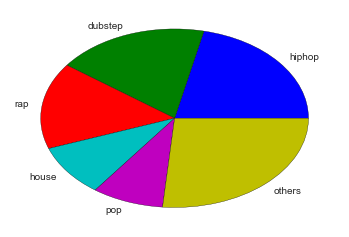

In [67]:
sorted_top_genres = sorted(top_genres, key=lambda x: x[1], reverse=True)
top_four = sorted_top_genres[:5]
others = 0
for genre in sorted_top_genres[5:]:
    others += genre[1]
labels = [elem[0] for elem in top_four]
labels.append('others')
values = [elem[1] for elem in top_four]
values.append(others)
plt.pie(values, labels=labels)
plt.show()

In [68]:
sorted_values = user.library.sort_values('count', ascending=False).values
top_five_values = sorted_values[:6, -1]
top_five_names = sorted_values[:6, 0]
top_five_values, top_five_names

(array([147, 136, 132, 127, 123, 120], dtype=object),
 array(['Playground [feat. Bugle & Arama]', 'Cracks - Flux Pavilion Remix',
        'Give Me Everything', 'The Hills', 'Dum Dee Dum', 'Legacy'], dtype=object))

## References
Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011)

John D. Hunter, "Matplotlib: A 2D Graphics Environment", Computin

Raschka, Sebastian, and Randal S. Olson. Python Machine Learning: Unlock Deeper Insights into Machine    Learning with This Vital Guide to Cutting-edge Predictive Analytics. Birmingham: Packt, 2015. Print.g in Science & Engineering, vol.9, no. 3, pp. 90-95, May/June 2007, doi:10.1109/MCSE.2007.55  

In [69]:
history_df[history_df['track_name'] == 'Pvrple Forest - Original Mix']
## COUNTING DOESN'T WORK
# need to fix same count for same name tracks

,track_name,artists,date
61,Pvrple Forest - Original Mix,Ganz,1486852078
70,Pvrple Forest - Original Mix,Ganz,1486838416
98,Pvrple Forest - Original Mix,Ganz,1486696398
